In [1]:
import pandas as pd
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
# function to clean the data
# drop rows that contain na values
# change the date column do datetime objects
def clean_data(data):
    data = data.dropna()
    data.loc[:,('date')] = pd.to_datetime(data.loc[:,('date')])
    return data


#function to add target column to data
#data has to be only on a particular room
def grouped_targets(df):
    df_x = df[:len(df)-6].reset_index()

    df_co2       = df[6:len(df)].reset_index()["co2"]
    df_t_ambient = df[6:len(df)].reset_index()["t_ambient"]
    df_tvoc      = df[6:len(df)].reset_index()["tvoc"]

    df_x["co2_30min"]       = df_co2
    df_x["t_ambient_30min"] = df_t_ambient
    df_x["tvoc_30min"]      = df_tvoc

    df_x = df_x.drop(["date", "location_uuid", "index"], axis=1)
    return df_x

In [3]:
# read and clean client 3 data
client_3 = pd.read_csv('Export/client_3.csv')
client_3 = clean_data(client_3)

c:\Users\Dave Laptop\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
# read and clean client 3 data that contains calculated features but no weather features
calc_client_3_no_weather = pd.read_csv('Export/calc_measures_client_3_no_weather.csv')
calc_client_3_no_weather = calc_client_3_no_weather.drop(['Unnamed: 0', 'Date', 'Location'], axis=1)
calc_client_3_no_weather = clean_data(calc_client_3_no_weather)

In [8]:
# read and clean client 3 data with calculated and weather features
calc_client_3 = pd.read_csv('Export/calc_measures_client_3.csv')
calc_client_3 = calc_client_3.drop(['Unnamed: 0', 'Date', 'Location', 'YYYYMMDD_x', 'YYYYMMDD_y', 'HH', 'MM', '# STN', 'DATE'], axis=1)
calc_client_3 = clean_data(calc_client_3)

In [4]:
#split data on rooms
client_3_rooms = [y for x, y in client_3.groupby('location_uuid', as_index=False)]

#compute targets per room and append to dataframe
df_3 = pd.DataFrame()
for room in client_3_rooms:
    df_3 = df_3.append(grouped_targets(room))

In [9]:
#split data on rooms
client_3_rooms = [y for x, y in calc_client_3_no_weather.groupby('location_uuid', as_index=False)]

#compute targets per room and append to dataframe
df_3_calc_no_weather = pd.DataFrame()
for room in client_3_rooms:
    df_3_calc_no_weather = df_3_calc_no_weather.append(grouped_targets(room))

In [10]:
#split data on rooms
client_3_rooms = [y for x, y in calc_client_3.groupby('location_uuid', as_index=False)]

#compute targets per room and append to dataframe
df_3_calc = pd.DataFrame()
for room in client_3_rooms:
    df_3_calc = df_3_calc.append(grouped_targets(room))

In [5]:
#some tvoc values are incorrect due to malfunction
#remove rows that contain extreme outliers
def drop_tvoc(dataframe):
    q75,q25 = np.percentile(dataframe.loc[:,'tvoc'],[75,25])
    intr_qr = q75-q25

    max_tvoc = q75+(1.5*intr_qr)
    min_tvoc = q25-(1.5*intr_qr)

    return(dataframe.loc[(dataframe['tvoc'] < max_tvoc) & (dataframe['tvoc'] > min_tvoc)])

In [11]:
#remove tvoc outliers
df_3                 = drop_tvoc(df_3)
df_3_calc            = drop_tvoc(df_3_calc)
df_3_calc_no_weather = drop_tvoc(df_3_calc_no_weather)

In [12]:
#define which dataset is used
dataframe = df_3

#to make RNN converge we normalize input values using a normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(dataframe.drop(['co2_30min', 't_ambient_30min', 'tvoc_30min'], axis=1))

#reshape data to fit RNN input as a sequence of data

#12 steps backwards * 5 minutes intervals = 1 hour of past data to predict 30 min ahead
steps_backwards = 12
#target values are already on the same row
steps_forward   = 0

#get input values
data_X = norm_layer(dataframe.drop(['co2_30min', 't_ambient_30min', 'tvoc_30min'], axis=1))
data_X = np.array(data_X)
#get target values
data_Y = dataframe[['co2_30min', 't_ambient_30min', 'tvoc_30min']][steps_backwards:len(dataframe)-steps_forward]

#reshape input features into shape(rows, steps backwards, amount of features)
series_reshaped_X =  np.array([data_X[i:i + steps_backwards].copy() for i in range(len(dataframe) - (steps_backwards+steps_forward))])

In [ ]:
#create train test split for RNN
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(series_reshaped_X, data_Y, 
    test_size=0.33, random_state=42)

In [ ]:
#rnn model
#standard keras sequential workflow
rnn_model = keras.Sequential()
rnn_model.add(layers.LSTM(32, input_shape=(steps_backwards, 23)))
rnn_model.add(layers.Dense(3))

rnn_model.summary()

In [ ]:
#compile RNN model
#standard keras sequential workflow
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    # List of metrics to monitor
    metrics=[]
)

In [ ]:
#train RNN model
#standard keras sequential workflow
history_rnn = rnn_model.fit(
    X_train_rnn,
    y_train_rnn,
    batch_size=64,
    epochs=128,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test_rnn, y_test_rnn),
)

In [ ]:
#plot training loss and validation loss against time to check overfitting
pd.DataFrame(history_rnn.history).plot(figsize=(8,5))
plt.show()

In [ ]:
#predict test data using RNN in order to plot
y_pred_rnn = pd.DataFrame(rnn_model.predict(X_test_rnn))

In [ ]:
#0 = co2, 1 = t_ambient, 2 = tvoc
#plot predicted values against target values
plt.figure()
plt.scatter(y_pred_rnn[2], y_test_rnn['tvoc_30min'], color="cornflowerblue",  alpha=0.4)
plt.ylim(0, 2500)
plt.xlim(0, 2500)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Recurrent Neural Network tvoc (no weather)")
plt.show()

In [13]:
#create train test split on non-reshaped data
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(['co2_30min', 't_ambient_30min', 'tvoc_30min'], axis=1), 
    dataframe[['co2_30min', 't_ambient_30min', 'tvoc_30min']], 
    test_size=0.33, random_state=42)

In [ ]:
#tree regression model using sklearn library
tree_regression = DecisionTreeRegressor(random_state=42)
tree_regression.fit(X_train, y_train)

#predict test data using regression tree in order to plot
y_pred_tree_regression = pd.DataFrame(tree_regression.predict(X_test))

#compute mean absolute error for comparison
mean_absolute_error(y_test, y_pred_tree_regression)

In [ ]:
#0 = co2, 1 = t_ambient, 2 = tvoc
#plot predicted values against target values
plt.figure()
plt.scatter(y_pred_tree_regression[2], y_test['tvoc_30min'], color="cornflowerblue",  alpha=0.4)
plt.ylim(0, 2500)
plt.xlim(0, 2500)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Regression Tree tvoc (no weather)")
plt.show()

In [14]:
#construct neural network model in similar fashion to RNN
nn_model_client_3 = keras.Sequential()
nn_model_client_3.add(keras.Input(shape=(X_train.shape[1],)))
nn_model_client_3.add(layers.BatchNormalization(axis=1))
nn_model_client_3.add(layers.Dense(64, activation="relu"))
nn_model_client_3.add(layers.Dense(64, activation="relu"))
nn_model_client_3.add(layers.Dense(3))
nn_model_client_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 11)               44        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5,167
Trainable params: 5,145
Non-trainable params: 22
_________________________________________________________________


In [15]:
#compile ANN model
nn_model_client_3.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    # List of metrics to monitor
    metrics=[],
)

In [16]:
#train ANN model
history = nn_model_client_3.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=32,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
)

Epoch 1/32
1238/1238 [==============================] - 4s 3ms/step - loss: 145.6815 - val_loss: 48.3191
Epoch 2/32
1238/1238 [==============================] - 3s 2ms/step - loss: 63.8974 - val_loss: 46.4396
Epoch 3/32
1238/1238 [==============================] - 3s 2ms/step - loss: 62.7274 - val_loss: 44.2278
Epoch 4/32
1238/1238 [==============================] - 3s 2ms/step - loss: 61.7485 - val_loss: 45.9326
Epoch 5/32
1238/1238 [==============================] - 3s 2ms/step - loss: 61.5816 - val_loss: 43.5075
Epoch 6/32
1238/1238 [==============================] - 3s 2ms/step - loss: 61.3357 - val_loss: 43.5257
Epoch 7/32
1238/1238 [==============================] - 3s 2ms/step - loss: 61.3681 - val_loss: 44.4128
Epoch 8/32
1238/1238 [==============================] - 3s 2ms/step - loss: 61.7893 - val_loss: 43.0823
Epoch 9/32
1238/1238 [==============================] - 3s 2ms/step - loss: 61.3060 - val_loss: 44.2597
Epoch 10/32
1238/1238 [==============================] - 3s 2ms

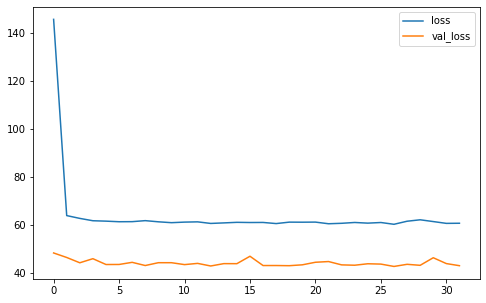

In [17]:
#plot training loss and validation loss against time to check overfitting
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [18]:
#predict test data using ANN in order to plot
y_pred_nn = pd.DataFrame(nn_model_client_3.predict(X_test))

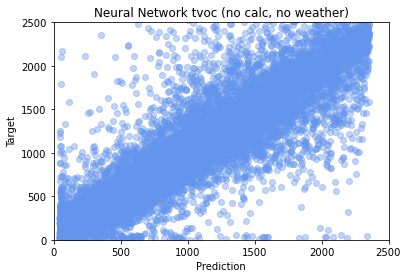

In [20]:
#0 = co2, 1 = t_ambient, 2 = tvoc
#plot predicted values against target values
plt.figure()
plt.scatter(y_pred_nn[2], y_test['tvoc_30min'], color="cornflowerblue",  alpha=0.4)
plt.ylim(0, 2500)
plt.xlim(0, 2500)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Neural Network tvoc")
plt.show()